In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# data from https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
df = pd.read_csv('AER_credit_card_data.csv')

## 0. Data preparation

 - Create the target variable by mapping yes to 1 and no to 0.
  - Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.


In [220]:
#@ INSPECTING DATAFRAME:
print(df.shape)

(1319, 12)


In [66]:
df.head()

card  reports       age  income     share  expenditure owner selfemp  \
0  yes        0  37.66667  4.5200  0.033270   124.983300   yes      no   
1  yes        0  33.25000  2.4200  0.005217     9.854167    no      no   
2  yes        0  33.66667  4.5000  0.004156    15.000000   yes      no   
3  yes        0  30.50000  2.5400  0.065214   137.869200    no      no   
4  yes        0  32.16667  9.7867  0.067051   546.503300   yes      no   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5

In [67]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [68]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [194]:
#above_average = df.median_house_value.mean()
#df.median_house_value = (data.card >= above_average).astype(int)
(df.card == 'yes').mean()

0.775587566338135

In [3]:
##turn card into binary 
df.card = (df.card == 'yes').astype(int)

In [4]:
df.head()

card  reports       age  income     share  expenditure owner selfemp  \
0     1        0  37.66667  4.5200  0.033270   124.983300   yes      no   
1     1        0  33.25000  2.4200  0.005217     9.854167    no      no   
2     1        0  33.66667  4.5000  0.004156    15.000000   yes      no   
3     1        0  30.50000  2.5400  0.065214   137.869200    no      no   
4     1        0  32.16667  9.7867  0.067051   546.503300   yes      no   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5

In [5]:
categorical = ['owner', 'selfemp', 'majorcards']
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'active']

In [6]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)


y_train = df_train.card.values
y_val = df_val.card.values

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

del df_train['card']
del df_val['card']

In [215]:
len(df_train), len(df_val), len(df_test), len(df)

(706, 349, 264, 1319)

In [76]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

## EDA

<ipython-input-200-0bdc3130cb34>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(bins=100, ax=ax, layout=(3, 3), column=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active",


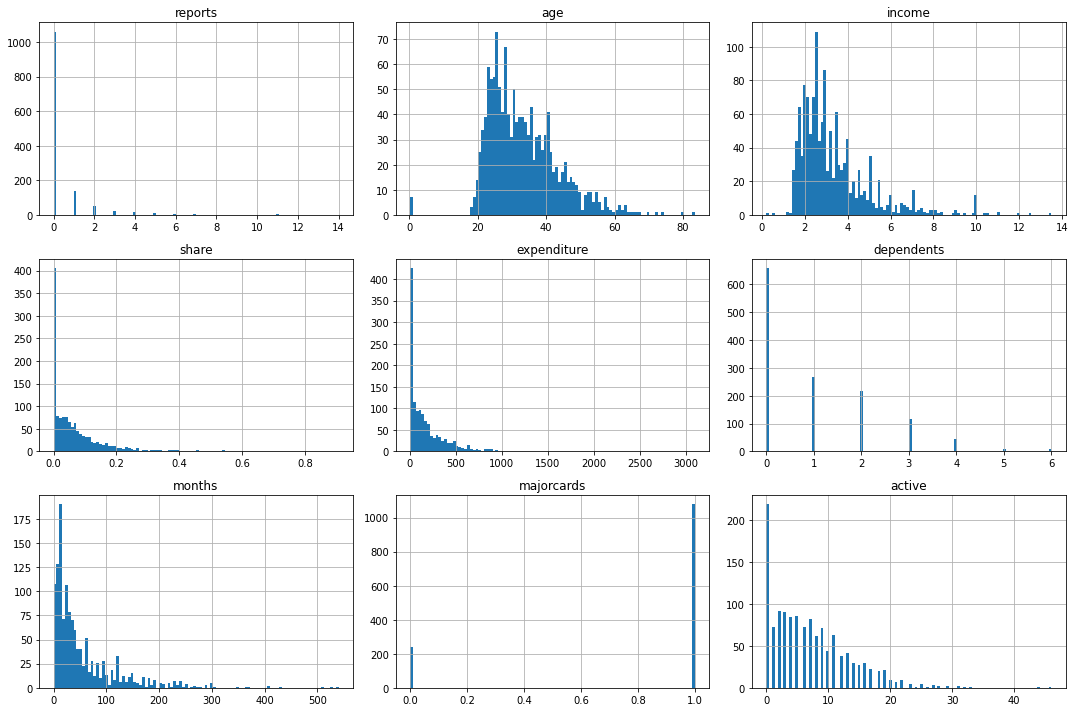

In [200]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df.hist(bins=100, ax=ax, layout=(3, 3), column=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", 
                                                  ])
plt.tight_layout()
plt.show()

In [201]:
np.mean(df.age),np.mean(df.income), np.mean(df.months), np.mean(df.active)

(33.21310325496589, 3.3653760424564068, 55.26762699014405, 6.99696739954511)

## Q.1. ROC AUC could also be used to evaluate feature importance of numerical variables.

 - For each numerical variable, use it as score and compute AUC with the card variable.
    Use the training dataset for that.
 - If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    reports
    dependents
    active
    share




In [13]:
df2 = df_train.sort_values('age')
auc(df2.age/df_train.age.max(),y_train)

TypeError: 'numpy.float64' object is not callable

In [19]:
for col in numerical:
    df2 = df_train.sort_values(col)
    score = auc(df2[col]/df_train[col].max(),y_train)
    if score < 0.5:
        score = auc(- df2[col]/df_train[col].max(),y_train)
    print('%9s, %.4f' % (col, score))

  reports, 0.7857
      age, 0.7944
   income, 0.7319
    share, 0.7896
expenditure, 0.6511
dependents, 0.9167
   months, 0.6519
   active, 0.6957


In [16]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print('%9s, %.4f' % (col, auc))

  reports, 0.7181
      age, 0.5363
   income, 0.5889
    share, 0.9936
expenditure, 0.9937
dependents, 0.5262
   months, 0.5358
   active, 0.5952


In [207]:
def mutual_info(series):
    return mutual_info_score(series, y_train)

In [209]:
for col in categorical:
    score = df_train[col].apply(mutual_info)
    print(round(score,2))

In [212]:
corr = corrMatrix.abs().unstack()
corr.sort_values

<bound method Series.sort_values of card    card           1.000000
        reports        0.452577
        age            0.000537
        income         0.094308
        share          0.388028
                         ...   
active  expenditure    0.054724
        dependents     0.107133
        months         0.100028
        majorcards     0.119603
        active         1.000000
Length: 100, dtype: float64>

In [211]:
corrMatrix = df.corr()
print(corrMatrix)

In [213]:
corrMatrix[corrMatrix< 1].unstack().transpose().sort_values( ascending=False).drop_duplicates()

expenditure  share          0.838779
months       age            0.436426
card         share          0.388028
             expenditure    0.365814
income       age            0.324653
dependents   income         0.317601
income       expenditure    0.281104
dependents   age            0.212146
active       reports        0.207755
age          active         0.181070
income       active         0.180540
             months         0.130346
majorcards   active         0.119603
             card           0.107769
             income         0.107138
dependents   active         0.107133
active       months         0.100028
card         income         0.094308
             active         0.080464
expenditure  majorcards     0.077514
active       expenditure    0.054724
expenditure  dependents     0.052664
share        majorcards     0.051470
reports      months         0.048968
months       dependents     0.046512
age          reports        0.044089
reports      dependents     0.019731
e

## Answer to the Q1 - dependents 0.9167


## Training the model
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [151]:
categorical + numerical

['owner',
 'selfemp',
 'majorcards',
 'reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'active']

In [261]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter = 1000)
    model.fit(X, y)

    return dv, model

In [262]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [263]:
dv, model = train(df_train, y_train, C = 1)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)

In [264]:
round(auc, 3)

0.991

In [181]:
auc = roc_auc_score(y_val, y_pred)

In [182]:
round(auc, 3)

0.993

## Answer to the Q.2 0.993

## Q.3 Precision and recall

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [222]:
accuracy_score(y_val, y_pred >= 0.5)

0.9627507163323782

In [232]:
thresholds = np.linspace(0, 1, 101) #np.linspace(0, 0+(0.01*101),101,endpoint=False)
accuracies = []
precision_all = []
recall_all = []

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <= t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precision_all.append(precision)
    recall_all.append(recall)
    
#    print('%0.2f %0.3f %0.3f %0.3f' % (t, acc, precision, recall))

In [278]:
thresholds = np.linspace(0, 1, 101) #np.linspace(0, 0+(0.01*101),101,endpoint=False)
scores = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <= t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision == recall):
        print(t)
    
    scores.append((t, tp, fp, fn, tn, acc, precision, recall ))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'acc', 'precision', 'recall' ] 
    
#df_scores
 

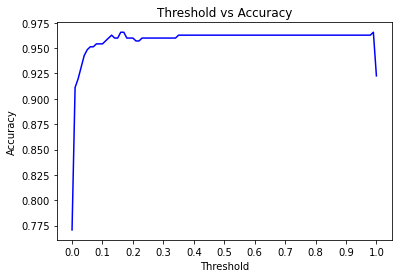

In [266]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='blue')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

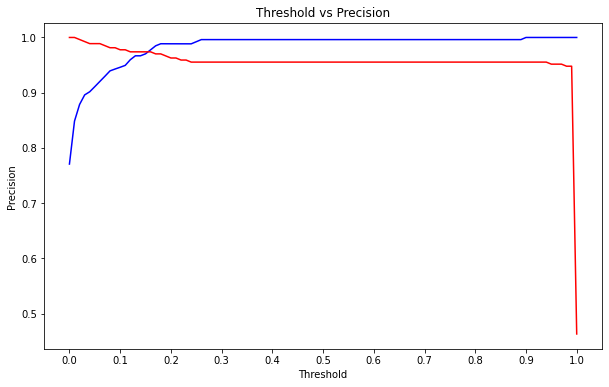

In [279]:
plt.figure(figsize=(10, 6))

plt.plot(df_scores.threshold, df_scores.precision, color='blue')
plt.plot(df_scores.threshold, df_scores.recall, color='red')

plt.title('Threshold vs Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

## Answer to the Q.3 - 0.1

## Q4. F1 score
Precision and recall are conflicting - when one grows, the other goes down. 
That's why they are often combined into the F1 score - a metrics that takes into account both

 - F1 = 2 P*R /(P + R)

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

In [281]:
thresholds = np.linspace(0, 1, 101) #np.linspace(0, 0+(0.01*101),101,endpoint=False)
scores = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <= t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2.*precision*recall /(precision + recall)
    
    scores.append((t, tp, fp, fn, tn, precision, recall, f1 ))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall' ,'f1' ] 
    
df_scores

threshold   tp  fp   fn  tn  precision    recall        f1
0         0.00  269  80    0   0   0.770774  1.000000  0.870550
1         0.01  269  48    0  32   0.848580  1.000000  0.918089
2         0.02  268  37    1  43   0.878689  0.996283  0.933798
3         0.03  267  31    2  49   0.895973  0.992565  0.941799
4         0.04  266  29    3  51   0.901695  0.988848  0.943262
..         ...  ...  ..  ...  ..        ...       ...       ...
96        0.96  256   0   13  80   1.000000  0.951673  0.975238
97        0.97  256   0   13  80   1.000000  0.951673  0.975238
98        0.98  255   0   14  80   1.000000  0.947955  0.973282
99        0.99  255   0   14  80   1.000000  0.947955  0.973282
100       1.00  232   0  269  80   1.000000  0.463074  0.633015

[101 rows x 8 columns]

In [282]:
df_scores.f1.max()

0.9793621013133208

In [283]:
df_scores.f1.idxmax()

18

In [284]:
df_scores.threshold[df_scores.f1.idxmax()]

0.18

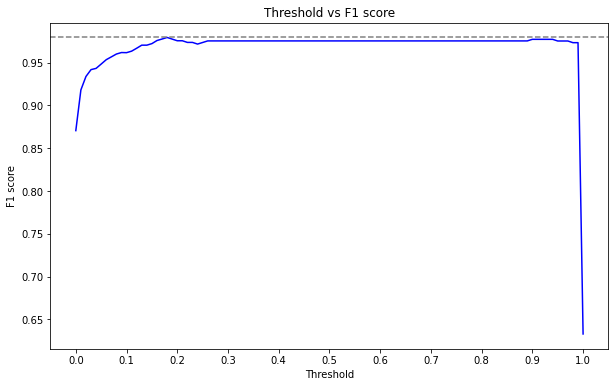

In [285]:
plt.figure(figsize=(10, 6))

plt.plot(df_scores.threshold, df_scores.f1, color='blue')
plt.axhline(y = df_scores.f1.max(), color = 'grey', linestyle = '--')
plt.title('Threshold vs F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 score')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

## Answer to Q.4 - ~ 0.1

## Q.5 Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

 - KFold(n_splits=5, shuffle=True, random_state=1)

 - Iterate over different folds of df_full_train
 - Split the data into train and validation
 - Train the model on train with these parameters:
    - LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
 - Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

In [288]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [289]:
train_idx, val_idx = next(kfold.split(df_train_full)) #split train into 2 parts

In [290]:
len(train_idx), len(val_idx), len(df_train_full)

(844, 211, 1055)

In [291]:
df_train = df_train_full.iloc[train_idx]
df_val = df_train_full.iloc[val_idx]

In [292]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter = 1000)
    model.fit(X, y)

    return dv, model

In [297]:
aucs = []
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.card.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C = 1.)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [298]:
aucs

[0.9941860465116279,
 0.9941176470588236,
 0.9943346508563901,
 0.9996107939802803,
 1.0]

In [299]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.996 ± 0.003


## Answer to the Q.5  - 0.003

## Q.6. use 5-Fold cross-validation to find the best parameter C

 - Iterate over the following C values: [0.01, 0.1, 1, 10] 
 - Initialize KFold with the same parameters as previously
 - Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
 - Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [301]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.992 ± 0.006
C=0.1, auc = 0.995 ± 0.004
C=1, auc = 0.996 ± 0.003
C=10, auc = 0.996 ± 0.003


 - If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Answer to the Q.6  - C = 1